# Transcription bare metal fine tuning!

### Prep for device config(device type = arm mac sillicon)

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio
import os 
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

import warnings
warnings.filterwarnings('ignore')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# mps config
import torch

device = "mps" if torch.backends.mps.is_available() else "cpu"
torch_dtype = torch.float16 if torch.backends.mps.is_available() else torch.float32

### Load Dataset

#### Split Into train, test, and validation

In [4]:
from datasets import load_dataset, DatasetDict

minds_de_ds = load_dataset('csv', data_files='./MInDS-14/text/de-DE.csv')

train_testvalid = minds_de_ds['train'].train_test_split(test_size=0.2)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

print(ds)

DatasetDict({
    train: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent'],
        num_rows: 488
    })
    test: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent'],
        num_rows: 62
    })
    valid: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent'],
        num_rows: 61
    })
})


python(36422) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36423) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [5]:
import os
import librosa

def load_audio_data(batch, audio_base_path):
    audio_files = [os.path.join(audio_base_path, filepath) for filepath in batch['filepath']]
    audio_data = [librosa.load(file_path, sr=None) for file_path in audio_files]
    
    # Separate audio data and sample rates
    audio_signals = [data[0] for data in audio_data]
    sample_rates = [data[1] for data in audio_data]
    
    batch['audio'] = [{'path': file_path, 'array': audio, 'sampling_rate': sr} for file_path, audio, sr in zip(audio_files, audio_signals, sample_rates)]
    return batch

In [6]:
# Apply the function to load audio data and add it to the dataset
audio_base_path = "./MInDS-14/audio"
ds = ds.map(load_audio_data, fn_kwargs={'audio_base_path': audio_base_path}, batched=True)
print(ds)

Map:   0%|          | 0/488 [00:00<?, ? examples/s]python(36424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36425) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Map: 100%|██████████| 61/61 [00:00<00:00, 328.64 examples/s]

DatasetDict({
    train: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent', 'audio'],
        num_rows: 488
    })
    test: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent', 'audio'],
        num_rows: 62
    })
    valid: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent', 'audio'],
        num_rows: 61
    })
})


In [7]:
# Remove the specified columns
ds = ds.remove_columns(["filepath","text_translated", "intent"])

#### Separate dataset for training

In [8]:
from datasets import Audio

ds = ds.cast_column("audio", Audio(sampling_rate=16_000))
ds2 = ds

### Prepare dataset!

In [9]:
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperProcessor
MODEL_NAME = "openai/whisper-small"
feature_extractor = WhisperFeatureExtractor.from_pretrained(MODEL_NAME)
tokenizer = WhisperTokenizer.from_pretrained(MODEL_NAME, language="german", task="transcribe")
processor = WhisperProcessor.from_pretrained(MODEL_NAME, language="german", task="transcribe")

In [10]:
print(ds["train"][0])

{'text_asr': 'hallo guten Morgen können Sie mir bitte meinen aktuellen Kontostand mitteilen', 'audio': {'path': None, 'array': array([0.00025965, 0.00029964, 0.00022703, ..., 0.00027563, 0.00022646,
       0.0001217 ]), 'sampling_rate': 16000}}


In [11]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["text_asr"]).input_ids
    return batch

In [12]:
ds = ds.map(prepare_dataset, remove_columns=ds.column_names["train"], num_proc=4)

python(36458) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36459) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36461) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Map (num_proc=4): 100%|██████████| 488/488 [00:13<00:00, 37.52 examples/s] 
python(36463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36466) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Map (num_proc=4): 100%|██████████| 62/62 [00:01<00:00, 45.43 examples/s]
python(36469) MallocStackLogging: can't turn off malloc stack loggi

#### Add Model and  the Config For Speccific Cases(german & transcribe)

In [13]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)

In [14]:
model.generation_config.language = "german"
model.generation_config.task = "transcribe"
model.generation_config.forced_decoder_ids = None

### Initialize Data Colator

In [15]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [16]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

### Define Metrics (WER)

In [17]:
import evaluate

metric = evaluate.load("wer")

In [18]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Training args & Phase

In [33]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-ger-lr1.5",  
    gradient_accumulation_steps=2,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=4,
    max_steps=61,
    gradient_checkpointing=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    save_steps=8,
    eval_steps=8,
    logging_steps=8,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
)

In [20]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

max_steps is given, it will override any value given in num_train_epochs


In [21]:
trainer.train()

  0%|          | 0/61 [00:00<?, ?it/s]Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...
 13%|█▎        | 8/61 [01:49<11:53, 13.46s/it]

{'loss': 0.9583, 'grad_norm': 11.097613334655762, 'learning_rate': 9.298245614035088e-06, 'epoch': 0.26}


You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, 50259], [2, 50359], [3, 50363]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
                                              
 13%|█▎        | 8/61 [03:00<11:53, 13.46s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873,

{'eval_loss': 0.6262494325637817, 'eval_wer': 19.68365553602812, 'eval_runtime': 71.6204, 'eval_samples_per_second': 0.866, 'eval_steps_per_second': 0.112, 'epoch': 0.26}


 26%|██▌       | 16/61 [06:22<16:28, 21.96s/it]

{'loss': 0.529, 'grad_norm': 7.425166130065918, 'learning_rate': 7.894736842105265e-06, 'epoch': 0.52}


                                               
 26%|██▌       | 16/61 [07:28<16:28, 21.96s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.41484466195106506, 'eval_wer': 17.04745166959578, 'eval_runtime': 66.3286, 'eval_samples_per_second': 0.935, 'eval_steps_per_second': 0.121, 'epoch': 0.52}


 39%|███▉      | 24/61 [09:18<08:54, 14.45s/it]

{'loss': 0.3983, 'grad_norm': 7.24657678604126, 'learning_rate': 6.491228070175439e-06, 'epoch': 0.79}


                                               
 39%|███▉      | 24/61 [10:18<08:54, 14.45s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.3997698724269867, 'eval_wer': 15.905096660808434, 'eval_runtime': 59.4548, 'eval_samples_per_second': 1.043, 'eval_steps_per_second': 0.135, 'epoch': 0.79}


 52%|█████▏    | 32/61 [11:59<06:34, 13.62s/it]

{'loss': 0.3421, 'grad_norm': 6.3821868896484375, 'learning_rate': 5.087719298245615e-06, 'epoch': 1.05}


                                               
 52%|█████▏    | 32/61 [12:58<06:34, 13.62s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.38299596309661865, 'eval_wer': 15.641476274165203, 'eval_runtime': 58.4402, 'eval_samples_per_second': 1.061, 'eval_steps_per_second': 0.137, 'epoch': 1.05}


 66%|██████▌   | 40/61 [14:42<04:54, 14.01s/it]

{'loss': 0.2149, 'grad_norm': 3.1096808910369873, 'learning_rate': 3.6842105263157896e-06, 'epoch': 1.31}


                                               
 66%|██████▌   | 40/61 [15:40<04:54, 14.01s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.3769168555736542, 'eval_wer': 16.16871704745167, 'eval_runtime': 57.5948, 'eval_samples_per_second': 1.076, 'eval_steps_per_second': 0.139, 'epoch': 1.31}


 79%|███████▊  | 48/61 [17:18<02:56, 13.55s/it]

{'loss': 0.2295, 'grad_norm': 3.5152502059936523, 'learning_rate': 2.280701754385965e-06, 'epoch': 1.57}


                                               
 79%|███████▊  | 48/61 [18:15<02:56, 13.55s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.37503522634506226, 'eval_wer': 16.34446397188049, 'eval_runtime': 56.891, 'eval_samples_per_second': 1.09, 'eval_steps_per_second': 0.141, 'epoch': 1.57}


 92%|█████████▏| 56/61 [19:54<01:08, 13.61s/it]

{'loss': 0.223, 'grad_norm': 4.282607555389404, 'learning_rate': 8.771929824561404e-07, 'epoch': 1.84}


                                               
 92%|█████████▏| 56/61 [20:51<01:08, 13.61s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.3725997507572174, 'eval_wer': 16.34446397188049, 'eval_runtime': 56.5333, 'eval_samples_per_second': 1.097, 'eval_steps_per_second': 0.142, 'epoch': 1.84}


100%|██████████| 61/61 [21:54<00:00, 16.44s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}
There were missing keys in the checkpoint model loaded: ['p

{'train_runtime': 1319.5521, 'train_samples_per_second': 0.74, 'train_steps_per_second': 0.046, 'train_loss': 0.40416934060268717, 'epoch': 2.0}


TrainOutput(global_step=61, training_loss=0.40416934060268717, metrics={'train_runtime': 1319.5521, 'train_samples_per_second': 0.74, 'train_steps_per_second': 0.046, 'total_flos': 2.8165935071232e+17, 'train_loss': 0.40416934060268717, 'epoch': 2.0})

### Save model for inference!

In [28]:
model.save_pretrained(training_args.output_dir)
processor.save_pretrained(training_args.output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


[]

### Evaluate and Inference

In [23]:
import pandas as pd
trainer_history = pd.DataFrame(trainer.state.log_history)
trainer_history.groupby('step').first().reset_index()
trainer_history

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_wer,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.9583,11.097613,9.298246e-06,0.262295,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.262295,8,0.626249,19.683656,71.6204,0.866,0.112,NaN,NaN,NaN,NaN,NaN
2,0.5290,7.425166,7.894737e-06,0.524590,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.524590,16,0.414845,17.047452,66.3286,0.935,0.121,NaN,NaN,NaN,NaN,NaN
4,0.3983,7.246577,6.491228e-06,0.786885,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.786885,24,0.399770,15.905097,59.4548,1.043,0.135,NaN,NaN,NaN,NaN,NaN
6,0.3421,6.382187,5.087719e-06,1.049180,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,1.049180,32,0.382996,15.641476,58.4402,1.061,0.137,NaN,NaN,NaN,NaN,NaN
8,0.2149,3.109681,3.684211e-06,1.311475,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,1.311475,40,0.376917,16.168717,57.5948,1.076,0.139,NaN,NaN,NaN,NaN,NaN


### Evaluation
Lowest Wer scores actualy at the early phase of training and continue rose up until step XX and start declining! WER: XX%

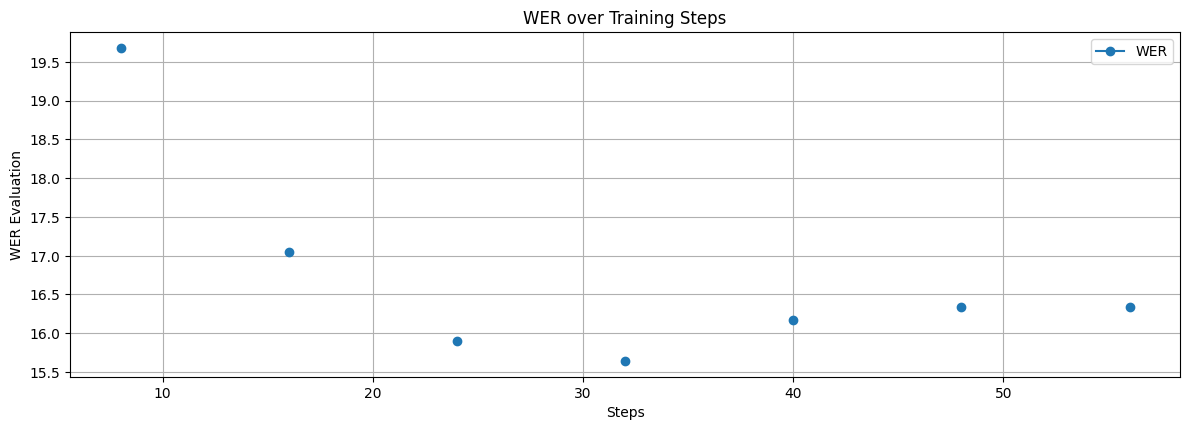

In [24]:
import matplotlib.pyplot as plt

# Plot WER over training steps
plt.figure(figsize=(12, 8))

# Plot WER
plt.subplot(2, 1, 1)
plt.plot(trainer_history['step'], trainer_history['eval_wer'], marker='o', label='WER')
plt.title("WER over Training Steps")
plt.xlabel("Steps")
plt.ylabel("WER Evaluation")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Inference

In [34]:
import time
from transformers import WhisperForConditionalGeneration, WhisperProcessor

# Define the path to the model checkpoint
model_path = "./whisper-small-ger-lr1.5"

# Load the best fine-tuned model
try:
    model = WhisperForConditionalGeneration.from_pretrained(model_path)
    processor = WhisperProcessor.from_pretrained(model_path)
    print("Model and processor loaded successfully.")
except OSError as e:
    print(f"Error loading model or processor: {e}")

# Inference function
def transcribe(audio):
    input_features = processor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt").input_features
    predicted_ids = model.generate(input_features)
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
    return transcription[0]

Model and processor loaded successfully.


### Inference Result

we got 0.5741 seconds for best inference and avg wer of 0.106%. Yeay!

### Little Bit of Demo for Spice it up
ps try to speak in german and let the fine tune model transcribe!

In [35]:
# Run inference on three samples
for i in range(3):
    sample = ds2["test"][i]
    
    start_time = time.time()
    transcription = transcribe(sample["audio"])
    end_time = time.time()
    
    inference_time = end_time - start_time
    
    print(f"Sample {i+1}:")
    print(f"Reference: {sample['text_asr']}")
    print(f"Prediction: {transcription}")
    print(f"Inference time: {inference_time:.4f} seconds")
    print()

# Calculate overall WER for these three samples
wer = metric.compute(predictions=[transcribe(ds2["test"][i]["audio"]) for i in range(3)],
                     references=[ds2["test"][i]["text_asr"] for i in range(3)])
print(f"WER for 3 samples: {wer}")

Sample 1:
Reference: Hallo ich versuche gerade auf meine bank wir wäre meines abzubekommen und ich komme einfach nicht dran rein können Sie mir da helfen bitte
Prediction: Hallo ich versuche gerade auf meine Bank wie wer meines abzubekommen und ich komme einfach nicht rein können Sie mir da helfen bitte
Inference time: 3.2295 seconds

Sample 2:
Reference: ja schönen guten Tag ich wollte mich mal erkundigen nach einem Kredit die nicht aufgenommen hatte schon meine Firma
Prediction: ja schönen guten Tag ich wollte mich mal erkundigen nach einem Kredit die nicht aufgenommen hatte für meine Firma
Inference time: 0.8977 seconds

Sample 3:
Reference: zeig mir meine Lastschriften
Prediction: zeig mir meine Lastschriften
Inference time: 0.5741 seconds

WER for 3 samples: 0.10638297872340426


In [ ]:
# !pip install sounddevice

### Little Bit of Demo for Spice it up
ps try to speak in german and let the fine tune model transcribe!

In [38]:
import sounddevice as sd
import numpy as np

# Function to record audio from the microphone
def record_audio(duration, sample_rate=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
    sd.wait()  # Wait until the recording is finished
    print("Recording finished.")
    audio = np.squeeze(audio)  # Remove single-dimensional entries
    return {"array": audio, "sampling_rate": sample_rate}

# Record audio from the microphone
duration = 5  # Record for 5 seconds
audio = record_audio(duration)

# Transcribe the recorded audio
transcription = transcribe(audio)
print("Transcription:", transcription)

Recording...
Recording finished.
Transcription: Hallo ich nehme Schobir
